<a href="https://colab.research.google.com/github/krislars/R-uncertainty/blob/master/MonteCarloModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import random
import numpy as np
import numpy.random as npRand
from matplotlib import pyplot as plt
import scipy.stats as stats

from matplotlib.widgets import Slider

In [3]:
%matplotlib inline

In [54]:
#Defining some parameters:
numVals = 10000
diffABmin = 0.9
diffABmax = 1.1
numSteps = 100

In [5]:
#MultiDimensional linspace
def ndlinspace(start, end, steps):
    if (start.shape != end.shape):
        print("Arrays must be same size")
        return
    if (start.ndim == 1):
        result = np.array(
            [np.linspace(s, e, steps) for s,e in zip(start, end)]
        )
        return result
    result = np.array(
        [ndlinspace(s, e, steps) for s,e in zip(start, end)]
    )
    return result

Data file format is intrinsic stellar H-K, sigma H-K, J-H, sigma J-H ... 
Davenport, J. R., Ivezic, Z., Becker, A. C., Ruan, J. J., Hunt-Walker, N. M., Covey, K. R., & Lewis, A. R. (2014, June). The SDSS-2MASS-WISE 10-dimensional stellar colour locus [Electronic version]. MNRAS, 440(4), 3430-3438.

$$
R = \frac{A-B}{C-D}
$$

We will choose values such that the numerator is diffAB.  So, $A=(diffAB)+B$.  We also choose the value of R to be 1.6, so $C-D=(diffAB)/1.6$.  Therefore, $C = (diffAB)/1.6+D$.

In [6]:
starData = np.loadtxt("https://raw.githubusercontent.com/krislars/R-uncertainty/master/Astro%20Lab%20Star%20Data.txt")
starData = np.transpose(starData)
B, dB = starData[0], starData[1]
D, dD = starData[2], starData[3]

diffAB = np.linspace(diffABmin, diffABmax, numSteps)
diffAB = np.transpose(ndlinspace(diffAB, diffAB, 50))

B, dB = ndlinspace(B,B,numSteps), ndlinspace(dB,dB,numSteps)
D, dD = ndlinspace(D,D,numSteps), ndlinspace(dD,dD,numSteps)

A = diffAB + B
C = diffAB/1.6 + D

dA = dC = np.linspace(0.02, 0.02, 50)
dA = dC = ndlinspace(dA, dA, numSteps)

This next line is propagation of error in an arithmetic function.

In [47]:
#calculating theoretical dR
dR = 1.6 *((dB**2 + dA**2)/diffAB + 1.6/diffAB *(dD**2 + dC**2))**0.5

This function takes a vector of values and a vector of associated uncertainties and returns an array of n = numVals samples selected randomly from a normal  probability distribution.

In [8]:
#choosing random data sets for each star type
def ndNormalData(mean, sigma, numVals):
    if (mean.shape != sigma.shape):
        print("Arrays must be same size")
        return
    if (mean.ndim == 1):
        data = np.array(
            [npRand.normal(m, s, numVals) for m, s in zip(mean, sigma)]
        )
        return data
    
    data = np.array(
        [ndNormalData(m, s, numVals) for m, s in zip(mean, sigma)]
    )
    return data

In [9]:
B_vals = ndNormalData(B, dB, numVals)
D_vals = ndNormalData(D, dD, numVals)
A_vals = ndNormalData(A, dA, numVals)
C_vals = ndNormalData(C, dC, numVals)

In [10]:
#calculating the "Monte Carlo" values for R and dR
R_vals = (A_vals - B_vals) / (C_vals - D_vals)
R_vals.shape

(50, 100, 10000)

Now, we can test the distributions of R.

In [11]:
R_mc = np.mean(R_vals, axis=2)
dR_mc = np.std(R_vals, axis=2)

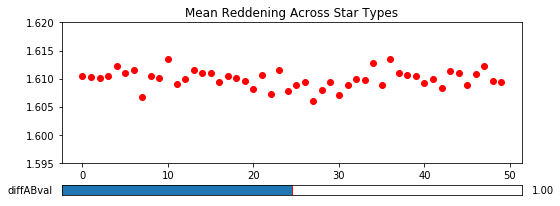

In [78]:
diffABinit = (diffABmin + diffABmax) /2

def findIndex(diffABval):
    step = (diffABmax - diffABmin) /numSteps
    result = (diffABval - diffABmin) /step
    return int(result)

x = np.arange(50)
fig = plt.figure(figsize=(8, 3))

red_ax = plt.axes([0.1, 0.2, 0.8, 0.65])
slider_ax = plt.axes([0.1, 0.05, 0.8, 0.05])

plt.sca(red_ax)
plt.title('Mean Reddening Across Star Types')
red_plot, = plt.plot(x, R_mc[x, findIndex(diffABinit)], 'ro')
plt.ylim(1.595,1.62)

diffAB_slider = Slider(slider_ax, 'diffABval', diffABmin, diffABmax, valinit = diffABinit)

def update(diffABval):
    red_plot.set_ydata(R_mc[x , findIndex(diffABval)])
    fig.canvas.sraw_idle()
    
diffAB_slider.on_changed(update)

plt.show()


Ideas going forward:
* Calculate the uncertainty in the mean.
* Try a weighted mean



In [1]:
#Defines binning of data to evenly space bins close to the mean
#and group the outer bins together. This avoids an expected bincount of 0
#for calculating chi-squared.
def customBinning(data, numBins=20, dataWidth=10):
    low = dataMin = min(data)
    high = dataMax = max(data)
    mean = np.mean(data)
    stdev = np.std(data)
    
    if (dataMin < mean - dataWidth * stdev):
        numBins -= numBins
        low = mean - dataWidth * stdev
    if (dataMax > mean + dataWidth * stdev):
        numBins -= numBins
        high = mean + dataWidth * stdev
    
    bins = np.linspace(low, high, numBins + 1)
    
    if (dataMin < low):
        bins = [dataMin] + bins
    if (dataMax > high):
        bins = bins + [dataMax]
    
    return bins

def ndHistogramCounts(Vals, numBins):
    if (Vals.ndim == 1):
        bins = customBinning(Vals, numBins)
        counts, Bins = np.histogram(Vals, bins)
        return counts
    
    results = np.stack(
        ndHistogramCounts(vals, numBins) for vals in Vals
    )
    
    return results

def ndHistogramBins(Vals, numBins):
    if (Vals.ndim == 1):
        bins = customBinning(Vals, numBins)
        counts, Bins = np.histogram(Vals, bins)
        return Bins
    
    results = np.stack(
        ndHistogramBins(vals, numBins) for vals in Vals
    )
    
    return results

def ndNormalCounts(mean, sigma, Bins):
    if (mean.shape != sigma.shape):
        print("Arrays must be same shape")
        return
    
    if (mean.ndim == 1):
        counts = np.diff(np.stack(
            stats.norm.cdf(bins, m, s) for bins, m, s in zip(Bins, mean, sigma)
        ))
        return counts
    
    counts = np.stack(
        ndNormalCounts(m, s, bins) for m, s, bins in zip(mean, sigma, Bins)
    )
    return counts


In [43]:
#Next I need to test "Goodness of fit"
numBins = 20
counts = ndHistogramCounts(R_vals, numBins)
Bins = ndHistogramBins(R_vals, numBins)

#calc expected with stats cdf and np.diff
exp = ndNormalCounts(R_mc, dR_mc, Bins)

#scale expected percentages by sample size
exp = numVals * exp

#Now calculate the Chi^2 values:
chi2 = np.sum(( (counts - exp)**2 / exp), axis=2)

In [44]:
#Plotting data sets with large Chi^2; looking for outliers
#Constraints in this case are the calculated mean, stdev, and total number of counts
c = 3
d = numBins - c
red_chi2 = chi2/d